In [6]:
import tensorflow as tf
from tensorflow.keras.applications import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.utils import *
from sklearn.metrics import *
from collections import Counter
import cv2
import seaborn as sn
#import preprocessing
from sklearn import preprocessing
from tqdm import tqdm
from io import BytesIO
from PIL import Image
from os import listdir
import matplotlib.pyplot as plt
from imageio import imread
from skimage.transform import resize
from sklearn.utils import compute_class_weight
from sklearn.model_selection import *
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
from skimage.io import *
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('OneDrive/Desktop/archive'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

OneDrive/Desktop/archive\cv10_labels.npy
OneDrive/Desktop/archive\test10_labels.npy
OneDrive/Desktop/archive\cv10_data\cv10_data.npy
OneDrive/Desktop/archive\test10_data\test10_data.npy
OneDrive/Desktop/archive\training10_0\training10_0.tfrecords
OneDrive/Desktop/archive\training10_1\training10_1.tfrecords
OneDrive/Desktop/archive\training10_2\training10_2.tfrecords
OneDrive/Desktop/archive\training10_3\training10_3.tfrecords
OneDrive/Desktop/archive\training10_4\training10_4.tfrecords


In [7]:
images=[]
labels=[]
feature_dictionary = {
    'label': tf.io.FixedLenFeature([], tf.int64),
    'label_normal': tf.io.FixedLenFeature([], tf.int64),
    'image': tf.io.FixedLenFeature([], tf.string)
    }

In [8]:
def _parse_function(example, feature_dictionary=feature_dictionary):
    parsed_example = tf.io.parse_example(example, feature_dictionary)
    return parsed_example

def read_data(filename):
    full_dataset = tf.data.TFRecordDataset(filename,num_parallel_reads=tf.data.experimental.AUTOTUNE)
    full_dataset = full_dataset.cache()
    print("Size of Training Dataset: ", len(list(full_dataset)))
    
    feature_dictionary = {
    'label': tf.io.FixedLenFeature([], tf.int64),
    'label_normal': tf.io.FixedLenFeature([], tf.int64),
    'image': tf.io.FixedLenFeature([], tf.string)
    }   

    full_dataset = full_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    print(full_dataset)
    for image_features in full_dataset:
        image = image_features['image'].numpy()
        image = tf.io.decode_raw(image_features['image'], tf.uint8)
        image = tf.reshape(image, [299, 299])        
        image=image.numpy()
        image=cv2.resize(image,(100,100))
        #image=cv2.merge([image,image,image])
        #image
        images.append(image)
        labels.append(image_features['label_normal'].numpy())

In [9]:
filenames=['OneDrive/Desktop/archive/training10_0/training10_0.tfrecords',
          'OneDrive/Desktop/archive/training10_1/training10_1.tfrecords',
          'OneDrive/Desktop/archive/training10_2/training10_2.tfrecords',
          'OneDrive/Desktop/archive/training10_3/training10_3.tfrecords',
          'OneDrive/Desktop/archive/training10_4/training10_4.tfrecords']

for file in filenames:
    read_data(file)
    
print(len(images))
print(len(labels))

Size of Training Dataset:  11177
<_ParallelMapDataset element_spec={'image': TensorSpec(shape=(), dtype=tf.string, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'label_normal': TensorSpec(shape=(), dtype=tf.int64, name=None)}>
Size of Training Dataset:  11177
<_ParallelMapDataset element_spec={'image': TensorSpec(shape=(), dtype=tf.string, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'label_normal': TensorSpec(shape=(), dtype=tf.int64, name=None)}>
Size of Training Dataset:  11177
<_ParallelMapDataset element_spec={'image': TensorSpec(shape=(), dtype=tf.string, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'label_normal': TensorSpec(shape=(), dtype=tf.int64, name=None)}>
Size of Training Dataset:  11177
<_ParallelMapDataset element_spec={'image': TensorSpec(shape=(), dtype=tf.string, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'label_normal': TensorSpec(shape=(), dtype=tf.int64, name=None

In [10]:
X=np.array(images)
y=np.array(labels)
print(y)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2021,shuffle=True,stratify=y)
(a,b,c)=x_train.shape 
x_train = np.reshape(x_train, (a, b, c, 1))
(a, b, c)=x_test.shape
x_test = np.reshape(x_test, (a, b, c, 1))
i=0
for value in y:
    if value == 1:
        i=i+1
print(i)
print(len(y))

[0 0 0 ... 0 0 0]
7289
55885


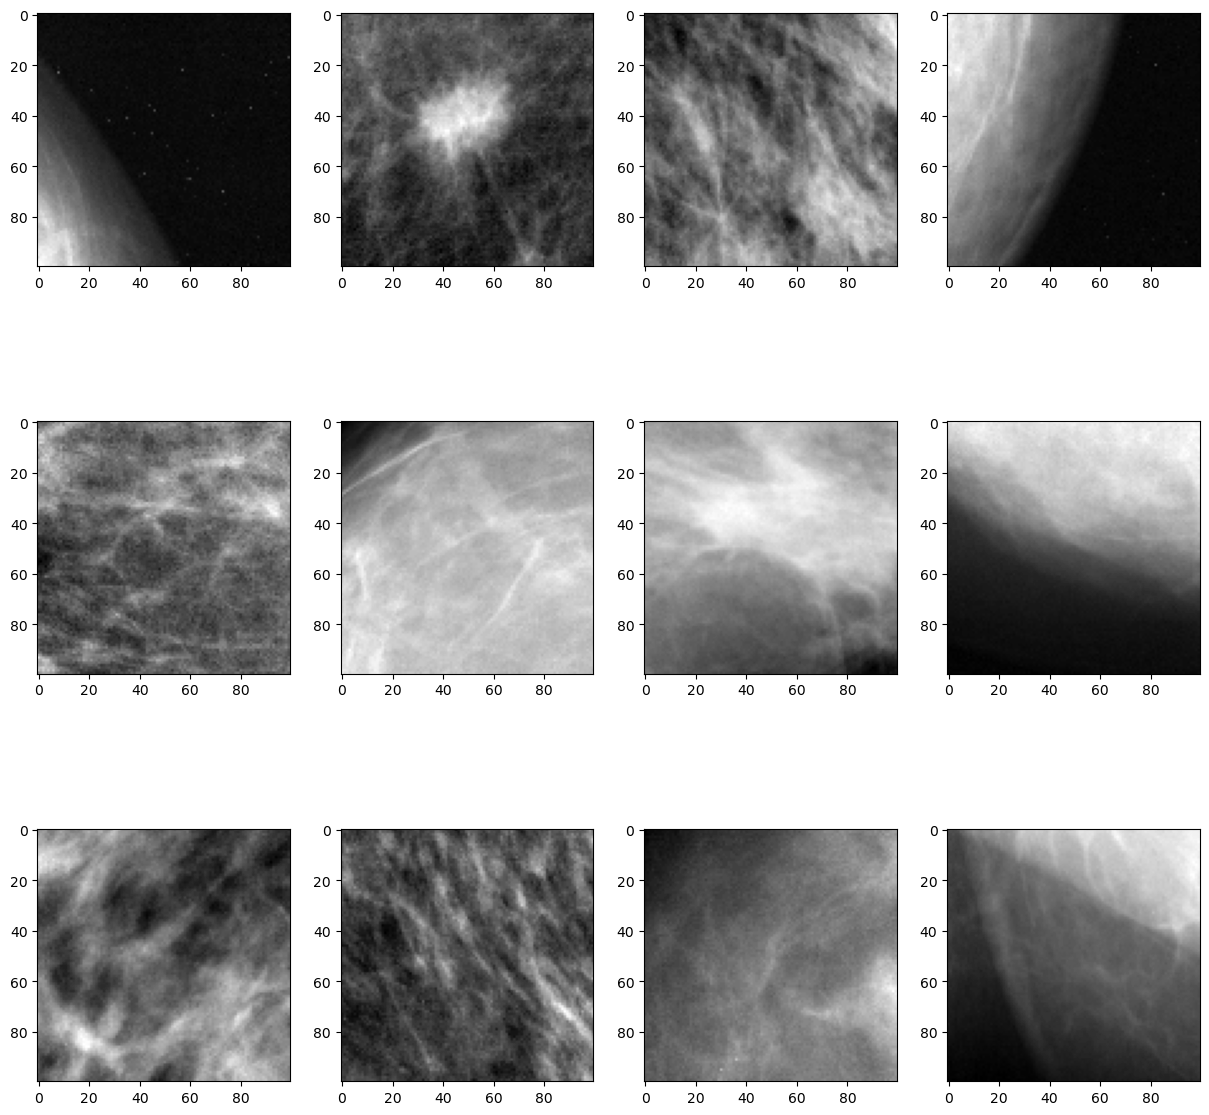

In [11]:
fig = plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns * rows + 1):
    img = np.random.randint(10)  # You may replace this line with your actual data
    fig.add_subplot(rows, columns, i)
    plt.imshow(x_train[i], cmap='gray')  # Use 'gray' colormap for grayscale images

plt.show()


In [12]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPool2D, Flatten
from keras import optimizers
from keras import losses
from sklearn import metrics

print(x_train[0].shape)

(100, 100, 1)


In [13]:
rows, cols,color = x_train[0].shape

model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', strides=(1, 1),input_shape=(rows,cols,1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))

model.add(Conv2D(64,(3,3),padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv2D(128,(3,3),padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv2D(256,(3,3),padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv2D(128,(3,3),padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv2D(64,(3,3),padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv2D(32,(3,3),padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      320       
                                                                 
 activation (Activation)     (None, 100, 100, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 50, 50, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 50, 50, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 25, 25, 64)        0         
 g2D)                                                 

In [14]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor='val_loss', mode='min', patience=20,restore_best_weights=True, verbose=1)

In [15]:
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train,validation_split=0.2,shuffle=True, epochs=50, batch_size=32)#,callbacks=[es])
loss_value , accuracy = model.evaluate(x_test, y_test)

print('Test_loss_value = ' +str(loss_value))
print('test_accuracy = ' + str(accuracy))

print(model.predict(x_test))


Epoch 1/50


1118/1118 [==============================] - 187s 166ms/step - loss: 0.3941 - accuracy: 0.8685 - val_loss: 1.2119 - val_accuracy: 0.8662
Epoch 2/50
1118/1118 [==============================] - 195s 175ms/step - loss: 0.3055 - accuracy: 0.8731 - val_loss: 0.5120 - val_accuracy: 0.8730
Epoch 3/50
1118/1118 [==============================] - 195s 174ms/step - loss: 0.2798 - accuracy: 0.8831 - val_loss: 0.3904 - val_accuracy: 0.8821
Epoch 4/50
1118/1118 [==============================] - 1762s 2s/step - loss: 0.2554 - accuracy: 0.8931 - val_loss: 0.3061 - val_accuracy: 0.8832
Epoch 5/50
1118/1118 [==============================] - 173s 154ms/step - loss: 0.2421 - accuracy: 0.8993 - val_loss: 0.3676 - val_accuracy: 0.8901
Epoch 6/50
1118/1118 [==============================] - 187s 167ms/step - loss: 0.2245 - accuracy: 0.9025 - val_loss: 0.3863 - val_accuracy: 0.8939
Epoch 7/50
1118/1118 [==============================] - 182s 163ms/step - loss: 0.2266 - accuracy: 0.9053 - val

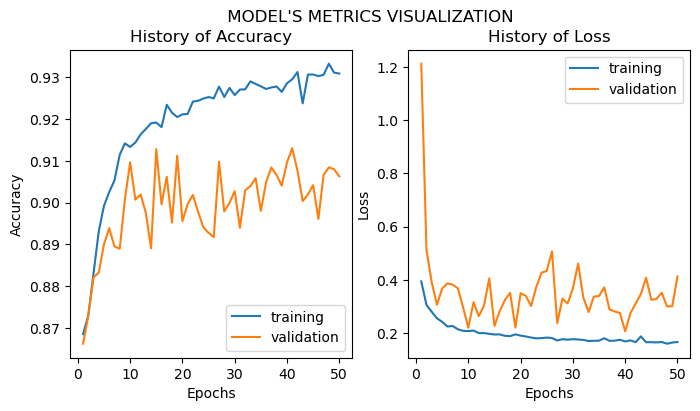

In [18]:
import matplotlib.pyplot as plt
def Train_Val_Plot(acc,val_acc,loss,val_loss):
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (8,4)) 
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")   

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'])

In [19]:
y_pred=model.predict(x_test)
threshold = 0.5
y_pred_binary = np.where(y_pred < threshold, 0, 1)

350/350 [==============================] - 14s 39ms/step


In [20]:
target=["0","1"]
from sklearn import metrics
print('Accuracy:', np.round(metrics.accuracy_score(y_test, y_pred_binary),4))
print('Precision:', np.round(metrics.precision_score(y_test, y_pred_binary, average='weighted'),4))
print('Recall:', np.round(metrics.recall_score(y_test,y_pred_binary, average='weighted'),4))
print('F1 Score:', np.round(metrics.f1_score(y_test, y_pred_binary, average='weighted'),4))
print('\t\tClassification Report:\n', metrics.classification_report(y_test, y_pred_binary,target_names=target))


Accuracy: 0.9062
Precision: 0.9094
Recall: 0.9062
F1 Score: 0.8843
		Classification Report:
               precision    recall  f1-score   support

           0       0.90      1.00      0.95      9719
           1       0.94      0.30      0.46      1458

    accuracy                           0.91     11177
   macro avg       0.92      0.65      0.70     11177
weighted avg       0.91      0.91      0.88     11177

